# 

In [ ]:
# unpack data
# !tar -xzvf JEOPARDY_QUESTIONS1.json.tar.gz

In [1]:
reset -fs

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

## Load and Prep Data

In [4]:
df = pd.read_json("JEOPARDY_QUESTIONS1.json")

In [5]:
df.head(10)

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680
5,3-LETTER WORDS,2004-12-31,"'In the title of an Aesop fable, this insect s...",$200,the ant,Jeopardy!,4680
6,HISTORY,2004-12-31,'Built in 312 B.C. to link Rome & the South of...,$400,the Appian Way,Jeopardy!,4680
7,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 8: 30 steals for the Birmingham Barons; 2...,$400,Michael Jordan,Jeopardy!,4680
8,EVERYBODY TALKS ABOUT IT...,2004-12-31,"'In the winter of 1971-72, a record 1,122 inch...",$400,Washington,Jeopardy!,4680
9,THE COMPANY LINE,2004-12-31,'This housewares store was named for the packa...,$400,Crate & Barrel,Jeopardy!,4680


In [6]:
# Existing category counts, desc
df.groupby('category').count()[['round']].sort_values(by=['round'], ascending=False).head(10)

,round
category,
BEFORE & AFTER,547
SCIENCE,519
LITERATURE,496
AMERICAN HISTORY,418
POTPOURRI,401
WORLD HISTORY,377
WORD ORIGINS,371
COLLEGES & UNIVERSITIES,351
HISTORY,349


# 0. Cleanup
Some cleanup/info
- [x] air-date to datetime
- [x] encode round
    - Daily Doubles are implicit from money value - Ignore
    - 3 Tiebreakers - Drop
- [ ] value to int/standardize money,  historical info [link](https://outsider.com/news/entertainment/jeopardy-show-double-dollar-values-categories/)
    - final question's have value np.nan
    - Rank question difficulty 1 through 11 (5 qn values 1st round, 5 qn values 2nd round, 1 final jeopardy)?
    - Or 1 through 13: 5 normal qn types plus daily double per round, times 2, and 1 final jeopardy
    - ~~for the pilot, questions values were 25-125 for first round, then doubled~~ pilot not in the data
    - Jeopardy! round was 100-500 for years
    - 11/26/01 doubled all monetary values, so 200-1000 for Jeopardy! round

In [7]:
df['air_date']= pd.to_datetime(df['air_date'])
df['year'] = df['air_date'].dt.year

df = df[df['round']!='Tiebreaker']

In [8]:
round_dict = {}
for idx, jp_round in enumerate(df['round'].unique()):
    round_dict[jp_round] = idx
round_dict

{'Jeopardy!': 0, 'Double Jeopardy!': 1, 'Final Jeopardy!': 2}

In [9]:
# df['enc_round'] = df['round'].map(round_dict)
df.replace({'round': round_dict}, inplace=True)

In [10]:
df.head(2)

,category,air_date,question,value,answer,round,show_number,year
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,0,4680,2004
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,0,4680,2004


In [ ]:
f"There are {df['category'].nunique():,} unique categories."

'There are 27,995 unique categories.'

In [ ]:
cts = df.groupby('category').count()
print(f"There are {cts[cts < 100].count()[0]:,} categories with less than 100 questions.")
print(f"There are {cts[cts >= 100].count()[0]:} categories with more than 100 questions.")

There are 27,845 categories with less than 100 questions.
There are 150 categories with more than 100 questions.


In [14]:
print(f'number of qn\'s with a hyper link: {np.sum(df["question"].str.contains("<a href")):,}')
# 10k / 300k

number of qn's with a hyper link: 10,523


---
# Q.1 Jeopardy Topics over Time

- (a) Annual Themes of questions asked during the three different rounds of the show
    - "Use LDA and/or NMF to identify topics of the questions asked during each portion, breaking up the documents according to year"
        - So as a first step, model over all years
        - Then change to model topics __per year__, and figure out topic comparisons

### Data Processing
- TFIDF to get the term-document matrix
- feed that into NMF or LDA 

In [15]:
qs = df['question']
samp = qs.sample(frac=0.1)

In [16]:
samp_df = df.loc[samp.index][['question', 'category', 'year']]

In [17]:
samp_df.head(2)

,question,category,year
129699,'The poem in which Walt Whitman modestly mused...,POETRY,1987
60608,"'In the 1850s Manet painted the <a href=""http:...",POTENT POTABLES,2005


In [18]:
len(samp), len(qs)

(21693, 216927)

In [20]:
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', max_df=0.95, min_df=3)  # we may need to find better stop words
# TODO: set ngram_range to (1,2) or (1,3)

# tfidf_qs = vectorizer.fit_transform(qs)
tfidf_qs = vectorizer.fit_transform(samp)

In [21]:
type(tfidf_qs), tfidf_qs[0], tfidf_qs.shape  # questions by vocab length

(scipy.sparse.csr.csr_matrix,
 <1x9811 sparse matrix of type '<class 'numpy.float64'>'
 	with 5 stored elements in Compressed Sparse Row format>,
 (21693, 9811))

Maybe we need to clean up the questions first so we don't get weird words like these. One way could be to increase 'max_df' for the vectorizer.

- seting `min_df=3` drops 90k total to 41k words
    - `default=1` means `min_df=3` is a $\geq$
    - still has '00' etc in it

In [94]:
# sorted(vectorizer.get_feature_names())[:10]

In [90]:
# look at the non-words in an individual question
np_tfidf = tfidf_qs.toarray()

In [22]:
# test_df = pd.DataFrame.sparse.from_spmatrix(tfidf_qs)  # sparse DF might be useful processing wise

In [23]:
# matches 
q1 = tfidf_qs[0].nonzero()[1]

idx_to_word = {idx: word for word, idx in vectorizer.vocabulary_.items()}
list(map(idx_to_word.get, q1)), samp.iloc[0]

(['sing', 'celebrate', 'whitman', 'walt', 'poem'],
 '\'The poem in which Walt Whitman modestly mused, "I celebrate myself and sing myself"\'')

    for i in range(m):
        _, cols = B[i, :].nonzero()
        for j in cols:
            <do some stuff>

In [24]:
# z = tfidf_qs.tocoo()
# row_ind = z.row

In [26]:
model = NMF(n_components=25, init='random', verbose=100)
W = model.fit_transform(tfidf_qs)  # document-topic matrix, rows=docs, cols=topic
# does W fit faster on the sparse matrix?
H = model.components_  # topic-term matrix, rows=topic, cols=terms

violation: 1.0
violation: 1.9595457675391204
violation: 0.9657083094573189
violation: 0.590981198823368
violation: 0.4060420235109818
violation: 0.289336282455987
violation: 0.22464188302461607
violation: 0.18483943796973176
violation: 0.14486619859487512
violation: 0.11379517470023959
violation: 0.09568815691246571
violation: 0.09005280266613444
violation: 0.08126343813843766
violation: 0.07299877488166369
violation: 0.07480555252020851
violation: 0.07612782152271955
violation: 0.06458073015457252
violation: 0.04991785136962376
violation: 0.040490765302344356
violation: 0.035384582641290234
violation: 0.03244894347946301
violation: 0.030382012838337687
violation: 0.0286763888090604
violation: 0.027149068401415326
violation: 0.026068070353708
violation: 0.024915836528650797
violation: 0.02375573955466644
violation: 0.022432662825654617
violation: 0.021079292016925447
violation: 0.019705030582295488
violation: 0.018299801382032476
violation: 0.016939491679219088
violation: 0.01563295601

In [27]:
NMF().get_params()

{'alpha': 0.0,
 'beta_loss': 'frobenius',
 'init': 'warn',
 'l1_ratio': 0.0,
 'max_iter': 200,
 'n_components': None,
 'random_state': None,
 'regularization': 'both',
 'shuffle': False,
 'solver': 'cd',
 'tol': 0.0001,
 'verbose': 0}

In [28]:
type(W), W.shape, W[0], np.argmax(W[0])

(numpy.ndarray,
 (21693, 25),
 array([0.00000000e+00, 1.83950060e-03, 0.00000000e+00, 3.38955687e-03,
        0.00000000e+00, 1.76788325e-03, 0.00000000e+00, 5.48636146e-03,
        5.29867278e-03, 0.00000000e+00, 2.73911254e-04, 1.30555618e-05,
        2.70161967e-03, 1.24729442e-03, 0.00000000e+00, 1.22755005e-03,
        4.93503879e-05, 0.00000000e+00, 7.07453633e-03, 0.00000000e+00,
        5.63322027e-04, 1.07629266e-03, 0.00000000e+00, 0.00000000e+00,
        4.35507860e-04]),
 18)

In [49]:
W.shape

(21693, 25)

In [50]:
np.sum(W, axis=0).shape

(25,)

<BarContainer object of 25 artists>

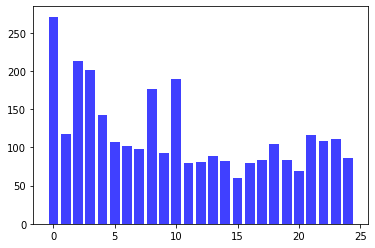

In [52]:
# for funsies
plt.bar(range(25), np.sum(W, axis=0), alpha=.75, color='blue');

In [36]:
# squash W by argmax along axis=1
print(W.shape)
samp_topics = np.argmax(W, axis=1)
samp_topics.shape

(21693, 25)


(21693,)

## Link `W[i]`s to year
Want to plot heatmap of counts per topic per year (large grid)

Have `H` and `samp` with index, go back and grab year 

In [ ]:
# get topic number per row by argmaxing the column dimension of W
samp_df['topic'] = np.argmax(W, axis=1)

In [40]:
samp_df.head(3)

,question,category,year,topic
129699,'The poem in which Walt Whitman modestly mused...,POETRY,1987,18
60608,"'In the 1850s Manet painted the <a href=""http:...",POTENT POTABLES,2005,0
73873,'Severe cases of this fever can cause jaundice...,INFECTIOUS DISEASES,2008,14


In [62]:
# counts per year per topic
z = samp_df.groupby(['year', 'topic'])['question'].count()

In [77]:
z

year  topic
1984  0         3
      1         6
      2         7
      3        14
      4        10
               ..
2012  20        4
      21       10
      22        3
      23        3
      24        4
Name: question, Length: 706, dtype: int64

In [69]:
# counts per year per topic
samp_df.groupby(['year'])['question'].count()

year
1984     116
1985      74
1986     129
1987     112
1988     139
1989     229
1990     429
1991     132
1992     195
1993     223
1994     102
1995      97
1996     480
1997    1369
1998    1331
1999    1315
2000    1301
2001    1179
2002     642
2003     950
2004    1333
2005    1422
2006    1379
2007    1364
2008    1372
2009    1426
2010    1374
2011    1367
2012     112
Name: question, dtype: int64

In [80]:
z.unstack(level=-2)

year,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
topic,,,,,,,,,,,,,,,,,,,,,
0,3.0,NaN,NaN,3.0,1.0,4.0,3.0,NaN,1.0,1.0,...,29.0,91.0,154.0,170.0,135.0,144.0,159.0,149.0,128.0,12.0
1,6.0,2.0,5.0,5.0,2.0,12.0,18.0,5.0,6.0,11.0,...,40.0,34.0,44.0,45.0,50.0,36.0,58.0,61.0,46.0,3.0
2,7.0,8.0,9.0,7.0,14.0,18.0,47.0,12.0,17.0,15.0,...,62.0,86.0,94.0,90.0,83.0,81.0,78.0,86.0,82.0,9.0
3,14.0,10.0,16.0,11.0,9.0,19.0,46.0,15.0,16.0,27.0,...,86.0,115.0,120.0,101.0,133.0,100.0,95.0,123.0,103.0,8.0
4,10.0,5.0,6.0,8.0,6.0,9.0,14.0,5.0,10.0,12.0,...,30.0,56.0,46.0,50.0,54.0,62.0,50.0,44.0,45.0,1.0
5,2.0,2.0,4.0,5.0,5.0,5.0,12.0,2.0,7.0,4.0,...,33.0,45.0,56.0,62.0,42.0,61.0,59.0,68.0,60.0,2.0
6,2.0,NaN,3.0,1.0,5.0,4.0,10.0,7.0,6.0,5.0,...,18.0,43.0,37.0,32.0,32.0,31.0,28.0,35.0,36.0,3.0
7,3.0,NaN,2.0,2.0,8.0,6.0,12.0,9.0,5.0,4.0,...,33.0,36.0,36.0,47.0,26.0,45.0,31.0,42.0,44.0,2.0
8,12.0,9.0,14.0,11.0,15.0,34.0,52.0,20.0,36.0,38.0,...,119.0,171.0,158.0,141.0,150.0,152.0,150.0,128.0,158.0,12.0


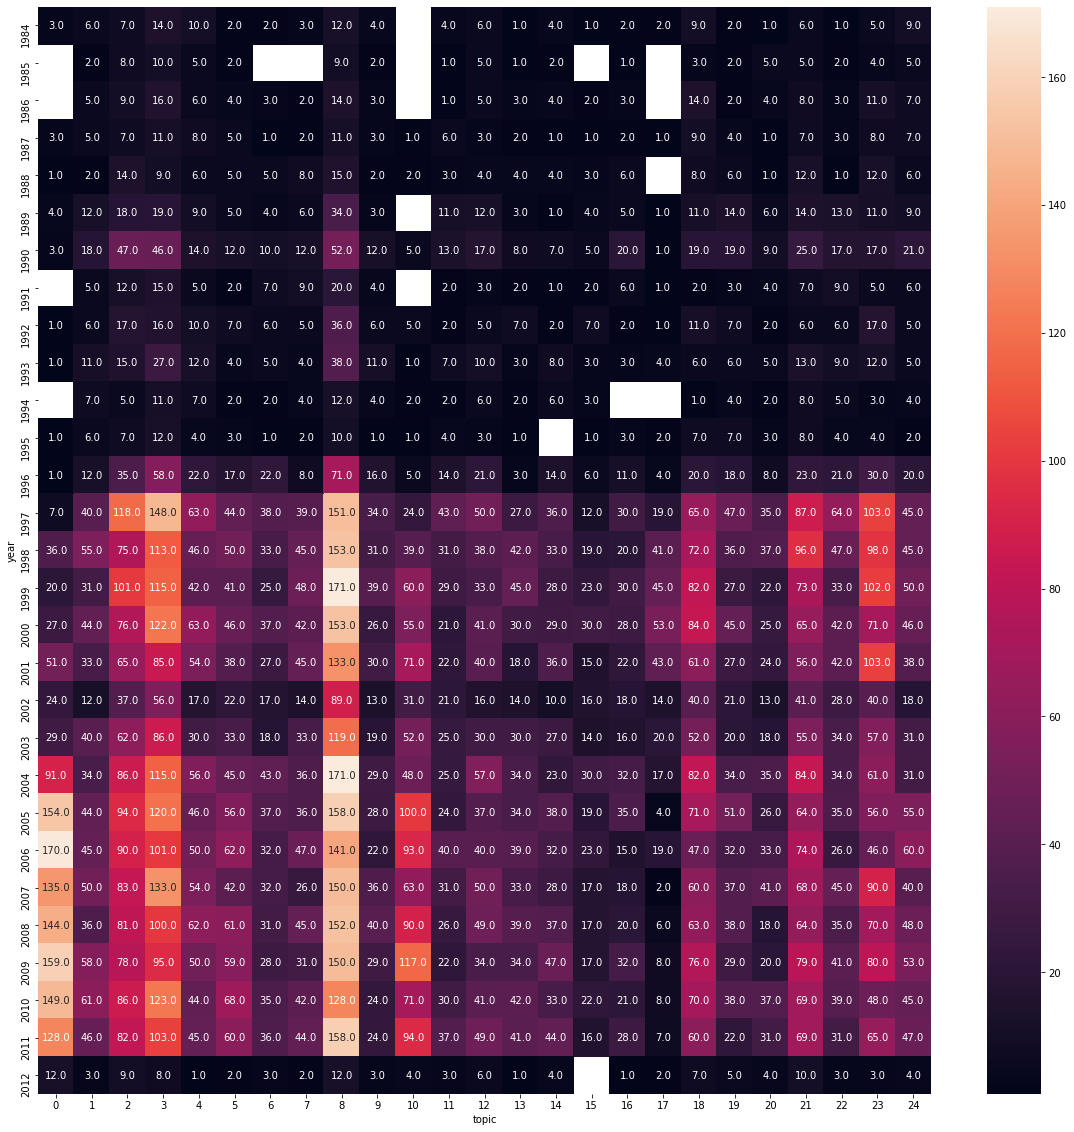

In [81]:
# z = np.array([[1,2],[3,4]])
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(z.unstack(), annot=True, fmt=',');

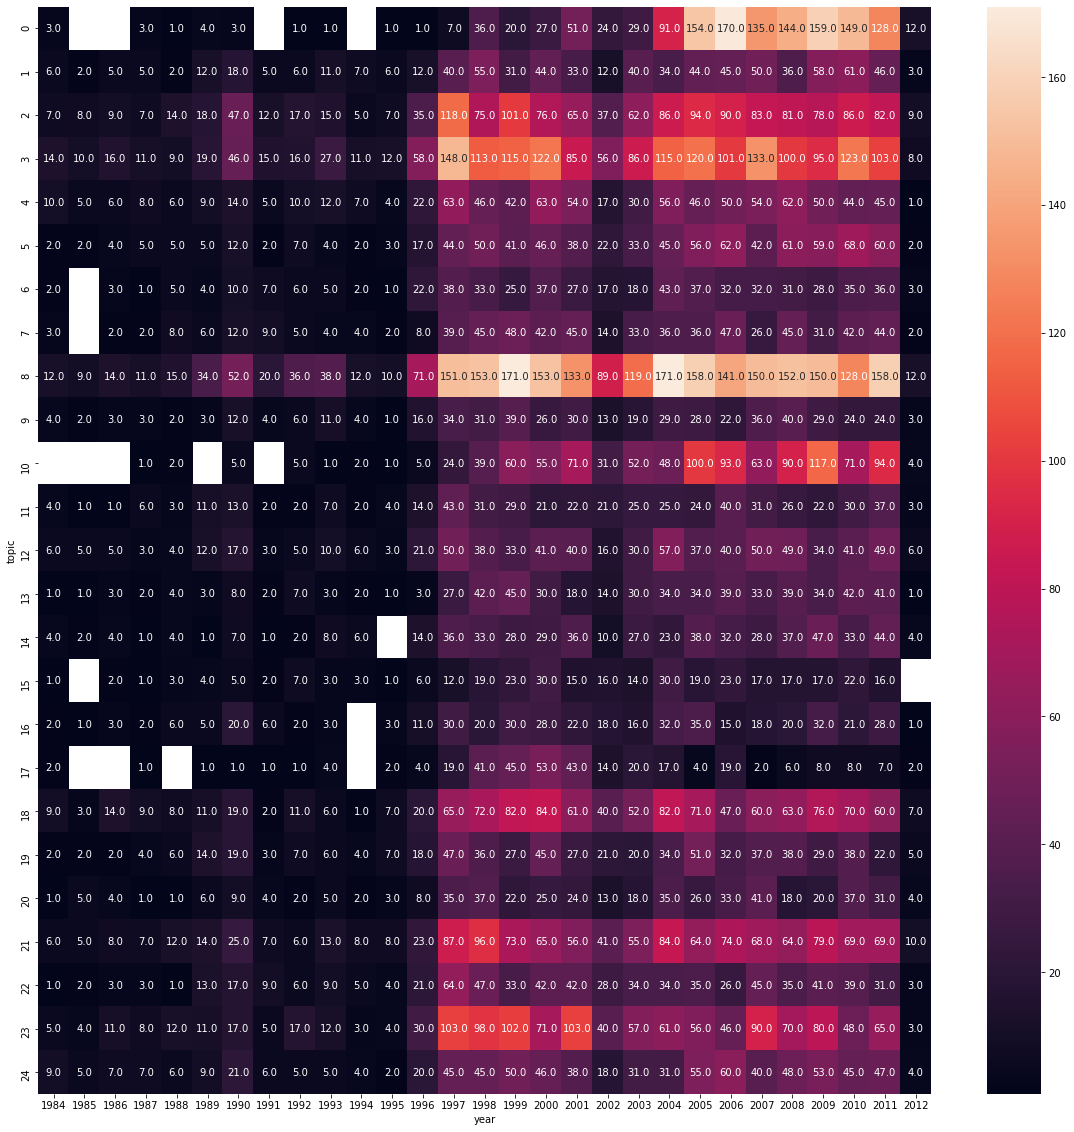

In [82]:
# z = np.array([[1,2],[3,4]])
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(z.unstack(level=-2), annot=True, fmt=',');

## Aside: Wordclouds
Looking to answer the question, what is this topic?
- tf_idf words in each topic's "documents" (questions)
- tf_idf words in each topic's "documents" category column


### Q1 continued
- Redo split by year